In [1]:
import ipyparallel as ipp
import psutil; n = min(psutil.cpu_count(logical=False), 8)
rc = ipp.Cluster(engines='mpi', n=n).start_and_connect_sync(activate=True)

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|█████████████████████████████████████████| 4/4 [00:07<00:00,  1.83s/engine]


In [2]:
%%px

"""
import the libraries, read the dataset, calculate the number of total cases, non-fraud cases, 
fraud cases, and percentage of fraud and non-fraud cases.
Download the data from here: https://www.kaggle.com/mlg-ulb/creditcardfraud
"""

import warnings
warnings.filterwarnings("ignore")
import bodo
import numpy as np
import pandas as pd

@bodo.jit
def load_data():
    df = pd.read_csv('data/creditcard.csv')
    cases = len(df)
    nonfraud_count = len(df[df.Class == 0])
    fraud_count = len(df[df.Class == 1])
    fraud_percentage = round(fraud_count/nonfraud_count*100, 2)
    nonfraud_percentage = 100 - fraud_percentage
    print('Total number of cases are ', cases)
    print('Number of Non-fraud cases are ', nonfraud_count)
    print('Number of fraud cases are', fraud_count)
    print('No Frauds', nonfraud_percentage, '% of the dataset')
    print('Frauds', fraud_percentage, '% of the dataset') 
    return df

df = load_data()

%px:   0%|                                             | 0/4 [00:13<?, ?tasks/s]

[stdout:0] Total number of cases are  284807
Number of Non-fraud cases are  284315
Number of fraud cases are 492
No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


%px: 100%|█████████████████████████████████████| 4/4 [00:13<00:00,  3.37s/tasks]


%px:  75%|███████████████████████████▊         | 3/4 [00:05<00:00, 28.37tasks/s]

[output:0]

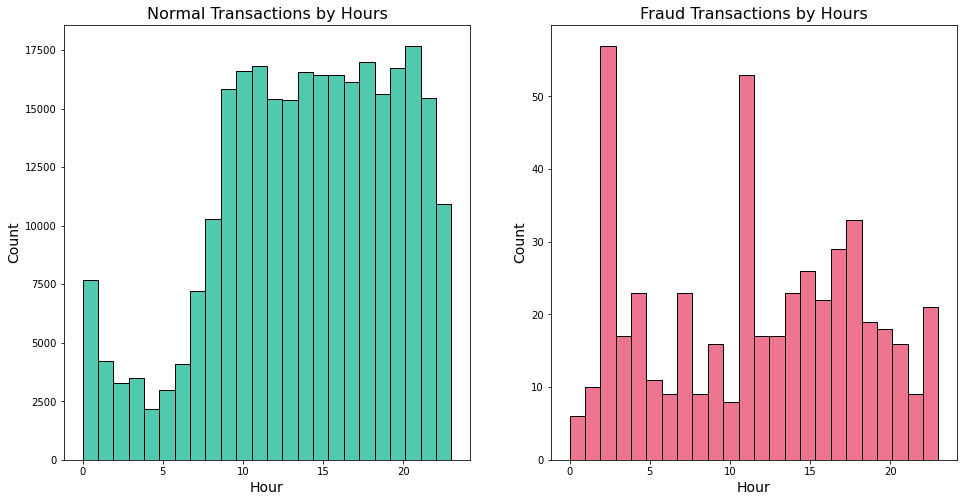

%px: 100%|█████████████████████████████████████| 4/4 [00:08<00:00,  2.02s/tasks]


In [3]:
%%px

"""
Visualize the distribution of Normal and Fraud transactions over 24 hours. 
"""

import seaborn as sns
import matplotlib.pyplot as plt

@bodo.jit
def gather_data():
    data = pd.read_csv('data/creditcard.csv')
    return bodo.gatherv(data)

data = gather_data()

if bodo.get_rank() == 0:
    
    timedelta = pd.to_timedelta(data['Time'], unit='s')
    data['Time_hour'] = (timedelta.dt.components.hours).astype(int)
    sns.color_palette("Paired")

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))


    sns.histplot(data[data['Class'] == 0]["Time_hour"], color='#17B895', bins = 24, ax = ax1)
    sns.histplot(data[data['Class'] == 1]["Time_hour"], color='#E8476A', bins = 24, ax = ax2)
    ax1.set_title('Normal Transactions by Hours', fontsize=16)
    ax2.set_title('Fraud Transactions by Hours', fontsize=16)
    ax1.set_xlabel("Hour", fontsize = 14)
    ax2.set_xlabel("Hour", fontsize = 14)
    ax1.set_ylabel("Count", fontsize = 14)
    ax1.set_ylabel("Count", fontsize = 14)
    ax2.set_ylabel("Count", fontsize = 14);

[output:0]

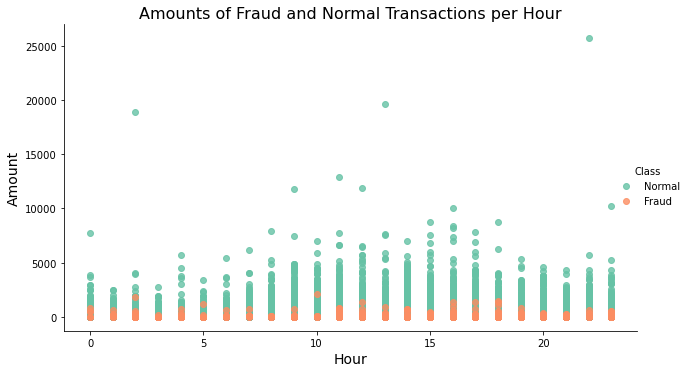

In [4]:
%%px

"""
Visualize the Amount of Fraud and Normal transactions per hour. 
"""

import seaborn as sns
import matplotlib.pyplot as plt

if bodo.get_rank() == 0:
    g = sns.lmplot(y="Amount", x="Time_hour", fit_reg=False, aspect=1.8, data=data, hue='Class', palette="Set2")
    new_labels = ["Normal", "Fraud"]
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    plt.title("Amounts of Fraud and Normal Transactions per Hour", fontsize=16)
    plt.xlabel("Hour", fontsize = 14)
    plt.ylabel("Amount", fontsize = 14);

In [5]:
%%px

"""
Scale the dataset with sklearn's StandardScaler
"""

from sklearn.preprocessing import StandardScaler 

@bodo.jit
def sc(df):
    df.drop('Time', axis = 1, inplace = True)
    sc = StandardScaler()
    scaled_amount = df['Amount'].values.reshape(-1,1)
    sc.fit(scaled_amount)
    df['Amount'] = (sc.transform(scaled_amount)).ravel()
    print(df['Amount'].head(10))
    return df
    
df = sc(df)

%px:   0%|                                             | 0/4 [00:06<?, ?tasks/s]

[stdout:0] 0    0.194691
1   -0.348926
2    1.042103
3    0.098052
4   -0.099927
5   -0.345300
6   -0.340417
7   -0.207925
8   -0.014054
9   -0.345263
Name: Amount, dtype: float64


%px: 100%|█████████████████████████████████████| 4/4 [00:06<00:00,  1.74s/tasks]


In [6]:
%%px

"""
Oversample from fraud class and undersample from non fraud class 
"""

@bodo.jit
def under_sample(df):
    df = bodo.random_shuffle(df, seed=42, parallel=True)
    # amount of fraud classes 492 rows.
    fraud_df = df.loc[df['Class'] == 1]
    non_fraud_df = df.loc[df['Class'] == 0][:492]

    normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

    # Shuffle dataframe rows
    new_df = bodo.random_shuffle(normal_distributed_df, seed=42, parallel=True)
    return new_df

new_df = under_sample(df)

%px: 100%|█████████████████████████████████████| 4/4 [01:29<00:00, 22.47s/tasks]


In [7]:
%%px

"""
Split data into test and train dataset
"""

from sklearn.model_selection import train_test_split # data split

@bodo.jit
def data_split(df):
    X = df.drop('Class', axis = 1).values
    y = df['Class'].values.astype(np.int64)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, train_size=0.8, random_state = 0)   
    print('X_train samples :', X_train[:1])
    print('X_test samples :', X_test[0:1])
    print('y_train samples :', y_train[0:20])
    print('y_test samples :', y_test[0:20])    
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = data_split(new_df)

%px:  75%|███████████████████████████▊         | 3/4 [00:22<00:00, 15.30tasks/s]

[stdout:0] X_train samples : [[-1.10912275  0.77517687  0.70725559 -1.24769287  0.31879859  0.79951918
   0.70224422  0.15599793 -0.00572861  0.22268477  0.53877106  0.71633767
   1.18940939 -0.26189307  0.6134282   0.49893003 -0.95871707  0.09884247
   0.59736133  0.24969963 -0.18926121  0.01984327  0.01340579 -1.27281864
  -0.43048315  0.87205372 -0.07044766 -0.31771691  0.01776091]]
X_test samples : [[ 2.07225254  0.00237296 -1.37125988  0.33600764  0.05785275 -1.27542692
   0.28708646 -0.41834804  0.55454508  0.00263507 -0.76857698  0.43060026
   0.43327839  0.41247467  0.71471392 -0.18878573 -0.57581462 -0.05738471
  -0.18048671 -0.20615661  0.24318171  0.87321199 -0.02808291 -0.06335972
   0.29711086 -0.1033173  -0.01876932 -0.05828655 -0.29403144]]
y_train samples : [0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 1]
y_test samples : [0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0]


%px: 100%|█████████████████████████████████████| 4/4 [00:22<00:00,  5.65s/tasks]


In [8]:
%%px

"""
Train a Logistic Regression and assess the model with accuracy_score, 
recall_score, precision_score, and f1_score. 
"""

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score 

@bodo.jit
def lr_model(X_train, X_test, y_train, y_test):
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    lr_yhat = lr.predict(X_test)
    print('Accuracy score of the Logistic Regression model is {}'.format(accuracy_score(y_test, lr_yhat)))
    print('Recall score of the Logistic Regression model is {}'.format(recall_score(y_test, lr_yhat)))
    print('Precision score of the Logistic Regression model is {}'.format(precision_score(y_test, lr_yhat)))
    print('F1 score of the Logistic Regression model is {}'.format(f1_score(y_test, lr_yhat)))
        
    
lr_model(X_train, X_test, y_train, y_test)

%px:   0%|                                             | 0/4 [00:02<?, ?tasks/s]

[stdout:0] Accuracy score of the Logistic Regression model is 0.983739837398374
Recall score of the Logistic Regression model is 0.9565217391304348
Precision score of the Logistic Regression model is 0.9565217391304348
F1 score of the Logistic Regression model is 0.9565217391304348


%px: 100%|█████████████████████████████████████| 4/4 [00:02<00:00,  1.45tasks/s]


In [12]:
%%px

"""
Train a Random Forest Classifier and assess the model with accuracy_score, 
recall_score, precision_score, and f1_score. 
"""

from sklearn.ensemble import RandomForestClassifier

@bodo.jit
def rf_model(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(max_depth = 4)
    rf.fit(X_train, y_train)
    rf_yhat = rf.predict(X_test)
    print('Accuracy score of the Random Forest model is {}'.format(accuracy_score(y_test, rf_yhat)))
    print('Recall score of the Random Forest model is {}'.format(recall_score(y_test, rf_yhat, average=None)))
    print('Precision score of the Random Forest model is {}'.format(precision_score(y_test, rf_yhat, average=None)))
    print('Accuracy score of the Random Forest model is {}'.format(f1_score(y_test, rf_yhat, average=None)))

rf_model(X_train, X_test, y_train, y_test)

[stdout:0] Accuracy score of the Random Forest model is 0.983739837398374
Recall score of the Random Forest model is [1.         0.91304348]
Precision score of the Random Forest model is [0.98039216 1.        ]
Accuracy score of the Random Forest model is [0.99009901 0.95454545]
